In [1]:
# load all the libraries that we need
import netCDF4 as nc4
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dateutil.parser
import datetime


# set the plot style
plt.style.use('seaborn-darkgrid')


 fraction of ensemble members with surviving forests = 0.9686411149825784


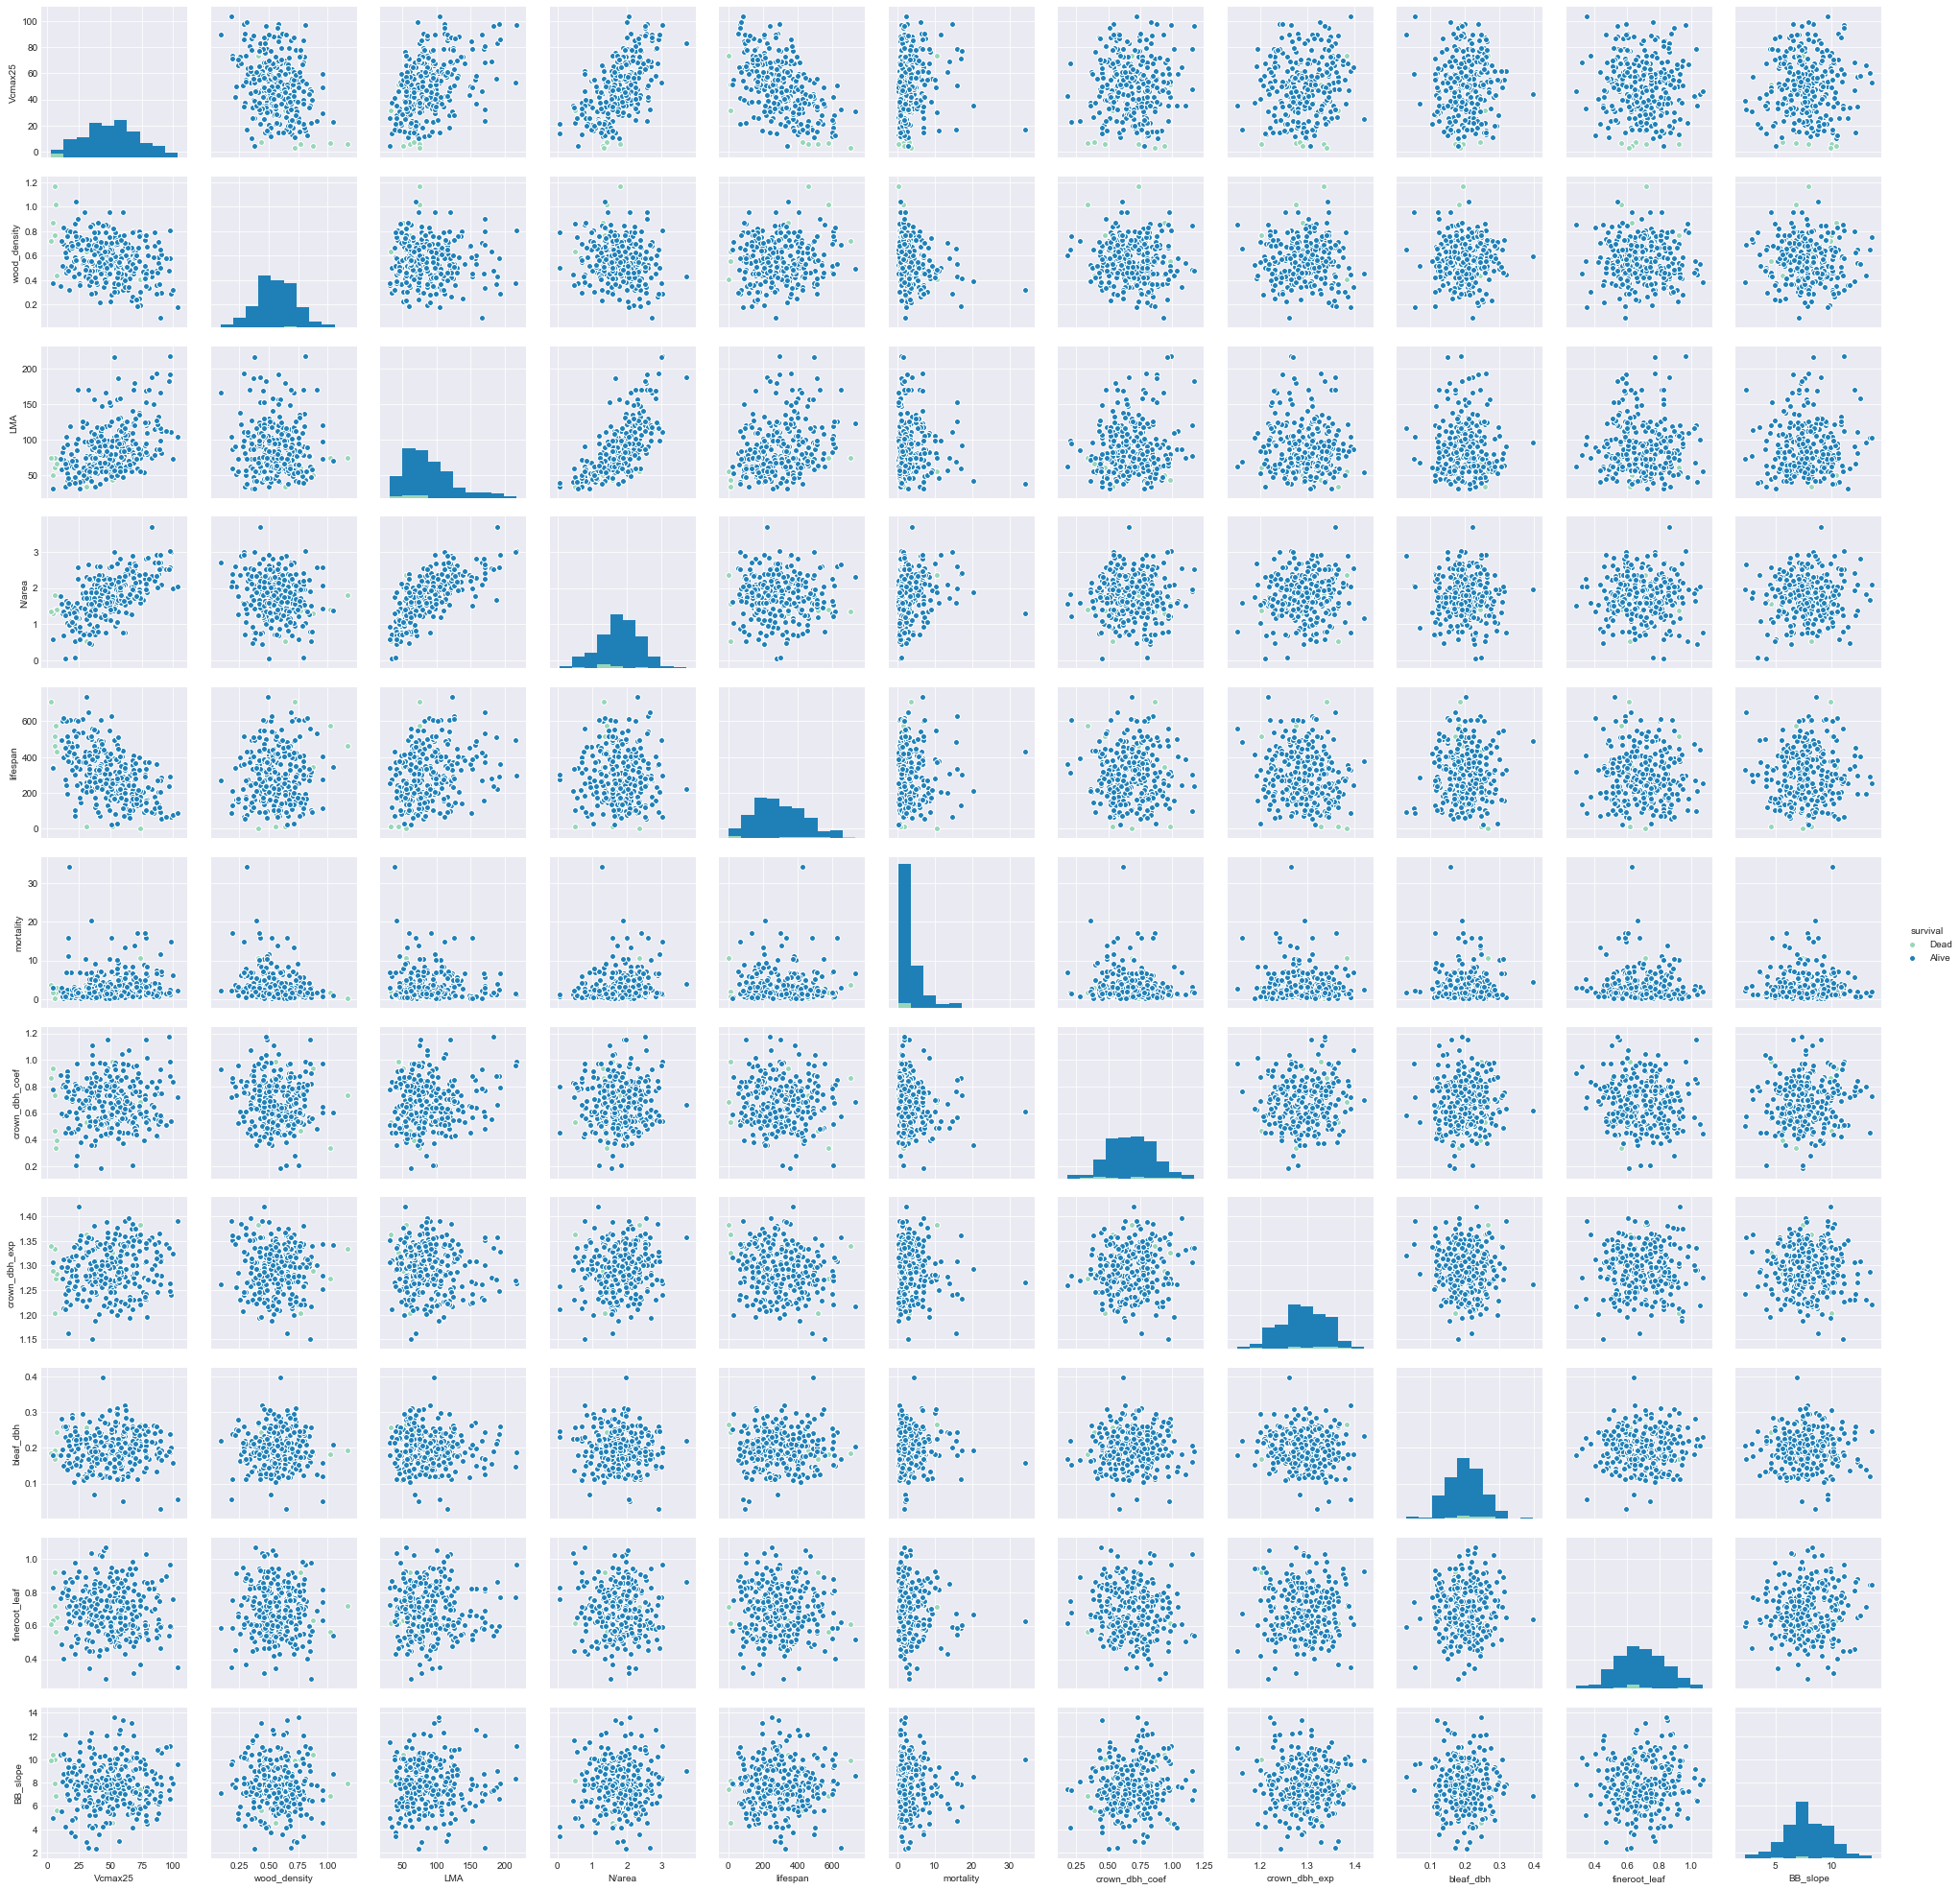

In [2]:
## load all the FATES history output, as well as teh traits matrix input to the model
## plot up the trait covariance matrix as colored by whether the ensemble lived or died

# ### uncomment this for bare-ground runs
#filename_history = '/Users/cdkoven/datasets/fates_output/bci_testbed/fates_clm5_fullmodel_bci_parameter_ensemble_1pft_v003_6341c18_819609f.h0.ensemble.sofar.nc'

# ### uncomment this for inventory runs
filename_history = '/Users/cdkoven/datasets/fates_output/bci_testbed/fates_clm5_fullmodel_bci_parameter_ensemble_1pft_v004inv_b1bf522_819609f.h0.ensemble.sofar.nc'
filename_params = '/Users/cdkoven/datasets/fates_output/bci_testbed/fates_params_c6ff126_bcitraits_test01_v_ensemble.c180529.nc'

histfile = nc4.Dataset(filename_history)
paramfile = nc4.Dataset(filename_params)
#print(histfile.variables)
biomass_var = histfile.variables['ED_biomass']
#print(biomass_var.shape)

nens = biomass_var.shape[0]
nts = biomass_var.shape[1]
nyears = nts/12

survival_threshold = 100.
survived = biomass_var[:,nts-1,0] > survival_threshold
print(' fraction of ensemble members with surviving forests = '+str(survived.sum()/float(nens)))


traits_matrix = np.loadtxt('traits_matrix_used_in_param_files_180529.txt')
column_names = ['Vcmax25', 'wood_density', 'LMA', 'N/area','lifespan','mortality','crown_dbh_coef','crown_dbh_exp','bleaf_dbh','fineroot_leaf','BB_slope']
ncols = len(column_names)

df_traits = pd.DataFrame(traits_matrix, columns=column_names)

#colors = 1. + 10. * survived
#pd.plotting.scatter_matrix(df_traits, alpha=0.7, figsize=(30,30), diagonal='hist', c=colors, s=80)

df_traits["survival"] = pd.cut(survived, bins=[-1,0.5,2.], labels=['Dead','Alive'])

survivalplot = sns.pairplot(df_traits, hue="survival",
                 hue_order=df_traits.survival.cat.categories,
                 palette="YlGnBu")


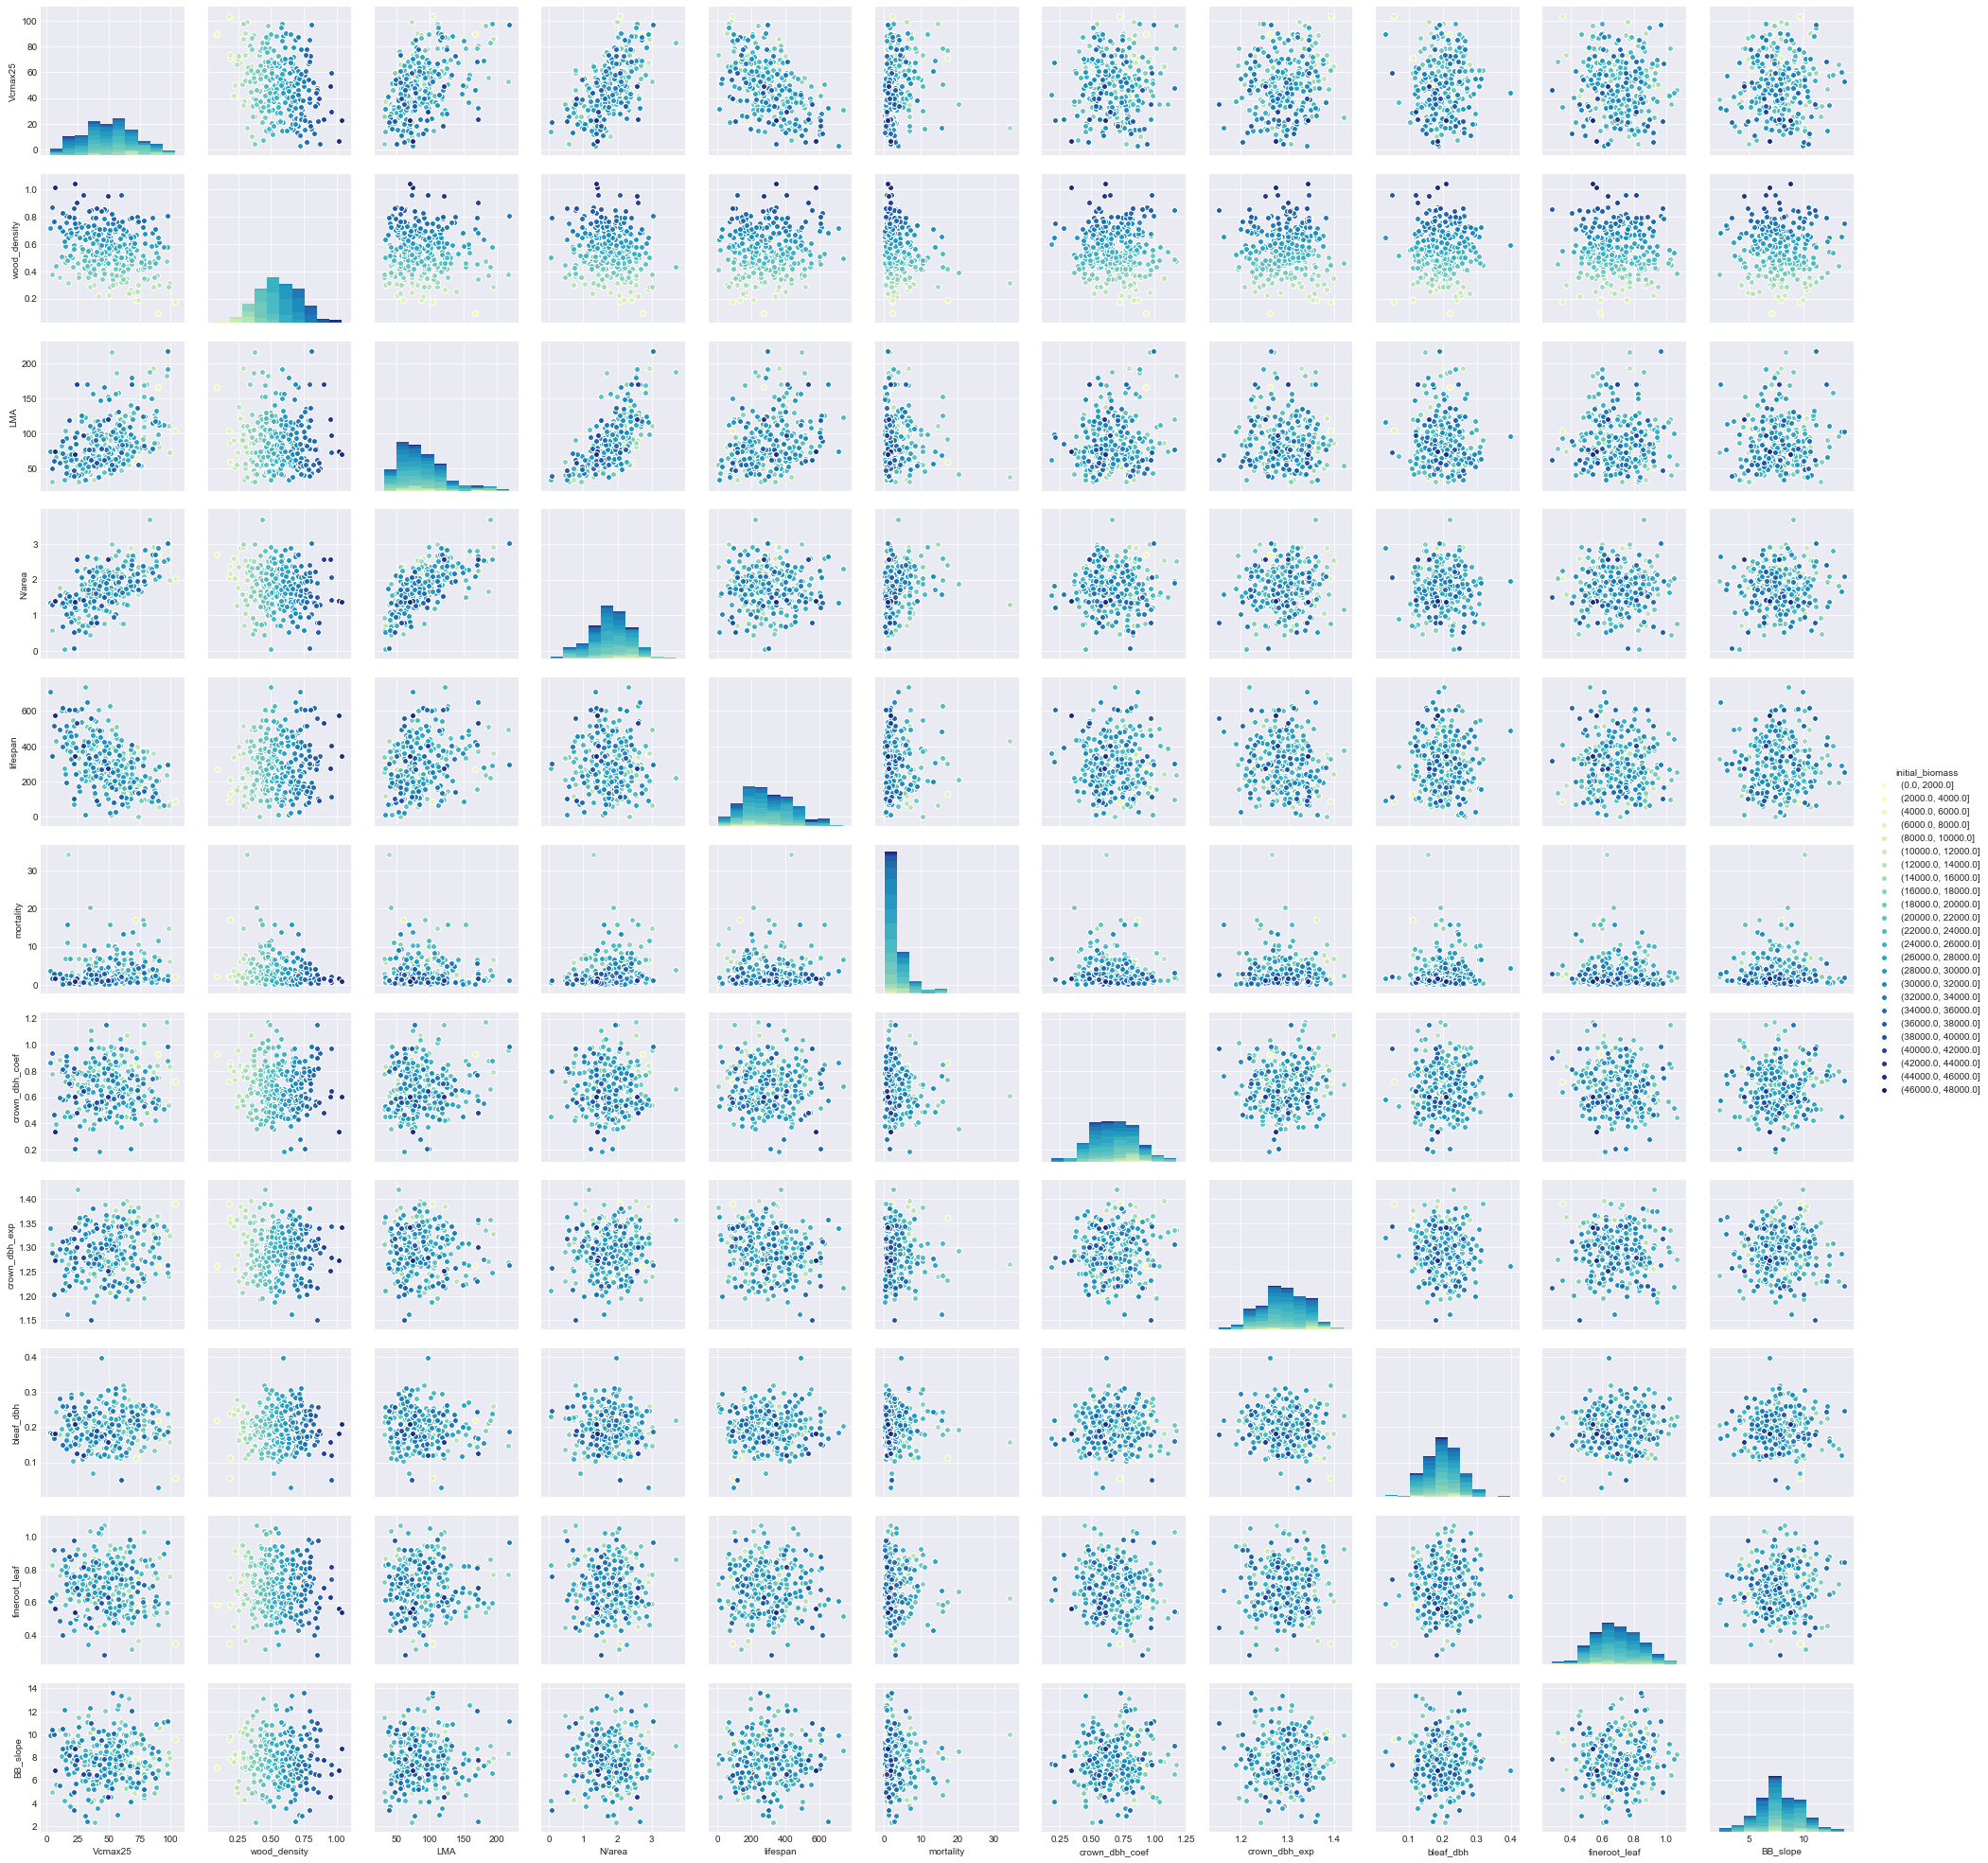

In [4]:
df_traits["initial_biomass"] = pd.cut(biomass_var[:,0,0], bins=np.arange(25)*2000.)

survivalplot = sns.pairplot(df_traits, hue="initial_biomass",
                 hue_order=df_traits.initial_biomass.cat.categories,
                 palette="YlGnBu")

In [ ]:
# plot a histogram of LAI values

mean_lai = histfile.variables['ELAI'][:,(nyears-10)*12:nyears*12,0].mean(axis=1)
lai_series = pd.Series(mean_lai, name='LAI')
sns.distplot(lai_series, kde=False, rug=False)

In [ ]:
# plot a joint ditribution of LAI and GPP values

mean_gpp = np.ma.masked_array(histfile.variables['GPP'][:,(nyears-10)*12:nyears*12,0].mean(axis=1) * 86400 *365, mask=np.logical_not(survived))

sns.jointplot(x=mean_lai, y=mean_gpp, kind="hex", color="k");


In [ ]:
## plot up the trait covariance matrix as colored by the final LAI


df_traits["mean_LAI"] = pd.cut(mean_lai, bins=np.arange(20)*.5)

laiplot = sns.pairplot(df_traits, hue="mean_LAI",
                 hue_order=df_traits.mean_LAI.cat.categories,
                 palette="YlGnBu")

In [ ]:
## plot the trait covariance matrix as colored by final mean GPP

df_traits["mean_gpp"] = pd.cut(mean_gpp, bins=np.arange(40)*100.)


gppscatterplot = sns.pairplot(df_traits, hue="mean_gpp",
                 hue_order=df_traits.mean_gpp.cat.categories,
                 palette="YlGnBu")

In [ ]:
### let's now plot the carbon use efficieny of the runs, 
### as projected onto the trait covariance matrix

mean_npp = histfile.variables['NPP'][:,(nyears-10)*12:nyears*12,0].mean(axis=1) * 86400 *365

mean_cue = np.ma.masked_array(mean_npp[:] / mean_gpp[:], mask=np.logical_not(survived))

df_traits["mean_cue"] = pd.cut(mean_cue, bins=np.arange(21)*.05)


cuescatterplot = sns.pairplot(df_traits, hue="mean_cue",
                 hue_order=df_traits.mean_cue.cat.categories,
                 palette="YlGnBu")

In [ ]:
### plot autotrophic respiration itself, projected onto TCM

mean_ar = histfile.variables['AR'][:,(nyears-10)*12:nyears*12,0].mean(axis=1) * 86400 *365

df_traits["mean_ar"] = pd.cut(mean_ar, bins=np.arange(20)*100.)


cuescatterplot = sns.pairplot(df_traits, hue="mean_ar",
                 hue_order=df_traits.mean_ar.cat.categories,
                 palette="YlGnBu")

In [ ]:
## plot the trait covariance matrix as colored by latent heat fluxes

mean_transp = np.ma.masked_array(histfile.variables['FCTR'][:,(nyears-10)*12:nyears*12,0].mean(axis=1))
mean_grndevap = np.ma.masked_array(histfile.variables['FGEV'][:,(nyears-10)*12:nyears*12,0].mean(axis=1))
mean_canevap = np.ma.masked_array(histfile.variables['FCEV'][:,(nyears-10)*12:nyears*12,0].mean(axis=1))

mean_lh = mean_transp + mean_grndevap + mean_canevap
print(mean_lh.max())
df_traits["mean_lh"] = pd.cut(mean_lh, bins=np.arange(20)*5.)
transpscatterplot = sns.pairplot(df_traits, hue="mean_lh",
                 hue_order=df_traits.mean_lh.cat.categories,
                 palette="YlGnBu")

In [ ]:
## now let's compare the seasonal cycles of GPP, LH, and SH against flux tower observations
### first load and process the eddy cvariance data

bci_fluxtower_datafilename = 'benchmark_datasets/BCI_v3.1.csv'

bci_fluxtower_data = np.genfromtxt(bci_fluxtower_datafilename, dtype={'names': ('date','tair','RH','vpd','p_kpa','PPT','Rs','Rs_dn','Rl_dn','Rl_up','Rnet','LE','H','Par_tot','Par_diff','SWC','ubar','ustar','WD','gpp','FLAG'),'formats': ('S16','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4')}, delimiter=',', skip_header=2)

ntim = len(bci_fluxtower_data)

time_start = datetime.datetime(2010, 1, 1, 0, 00)

tdelt = np.ma.masked_all(ntim)
month = np.ma.masked_all(ntim, dtype=np.int)
year = np.ma.masked_all(ntim, dtype=np.int)
gpp = np.ma.masked_all(ntim)
LE = np.ma.masked_all(ntim)
H = np.ma.masked_all(ntim)

for i in range(ntim):
    ts = dateutil.parser.parse(bci_fluxtower_data[i][0])
    tdelt[i] = (ts - time_start).days + (ts - time_start).seconds / 86400.
    month[i] = ts.month
    year[i] = ts.year
    gpp[i] = bci_fluxtower_data[i][19]
    LE[i] = bci_fluxtower_data[i][11]
    H[i] = bci_fluxtower_data[i][12]

H_masked = np.ma.masked_invalid(H)

nyears = (year.max() - year.min()) + 1
nmonths = nyears * 12

gpp_monthly = np.ma.masked_all(nmonths)
gpp_monthyear = np.ma.masked_all([nyears,12])
LE_monthyear = np.ma.masked_all([nyears,12])
H_monthyear = np.ma.masked_all([nyears,12])

for i in range(nyears):
    for j in range(12):
        mask = (year[:] == (year.min() + i)) * (month[:] == (j + 1))
        index = i*12 + j
        # gpp_monthly2[index] = gpp[mask].mean()                                                                                                                                                                                                                              
        if mask.sum() > 0:
            gpp_monthly[index] = (gpp * mask).sum() / mask.sum()
            gpp_monthyear[i,j] = gpp_monthly[index]
            LE_monthyear[i,j] = (LE * mask).sum() / mask.sum()
        H_monthyear[i,j] = H_masked[mask].mean()

months = np.arange(12)

### change gpp units to grams or carbon per meter squared per year
gpp_gcm2y = gpp_monthyear * 1e-6 * 12.0107 * (86400 * 365.25)


In [ ]:
# now lets plot the GPP from FATES and the tower data together

# calculate sesonal cycle of GPP from FATES ensembles
gpp_seascycle = np.ma.masked_all([nens, 12])
offset = 7  # first month is actually June, so I need to add this to get to January

startyear = 90
endyear = 99

for i in range(12):
    gpp_seascycle[:,i] = histfile.variables['GPP'][:,offset+i+(startyear)*12:offset+i+endyear*12:12,0].mean(axis=1) * 86400 *365

fig=plt.figure(figsize=(12, 6))

plt.plot(months, gpp_gcm2y.transpose(), marker='', linewidth=0.5, alpha=0.9, color='blue')

plt.plot(months, gpp_seascycle.transpose(), linewidth=0.15, alpha=0.9, color='green')

plt.title("Seasonal cycle of GPP", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Month")
plt.ylabel("GPP (g C / m2 / y)")

In [ ]:
# now lets plot the LH from FATES and the tower data together

# calculate sesonal cycle of LH from FATES ensembles
LH_seascycle = np.ma.masked_all([nens, 12])

for i in range(12):
    LH_seascycle[:,i] = histfile.variables['FCTR'][:,offset+i+(startyear)*12:offset+i+endyear*12:12,0].mean(axis=1)
    +histfile.variables['FGEV'][:,offset+i+(startyear)*12:offset+i+endyear*12:12,0].mean(axis=1)
    +histfile.variables['FCEV'][:,offset+i+(startyear)*12:offset+i+endyear*12:12,0].mean(axis=1)
    
fig=plt.figure(figsize=(12, 6))

plt.plot(months, LE_monthyear.transpose(), marker='', linewidth=0.5, alpha=0.9, color='blue')

plt.plot(months, LH_seascycle.transpose(), linewidth=0.15, alpha=0.9, color='green')

plt.title("Seasonal cycle of LH", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Month")
plt.ylabel("LH (W/m2)")

In [ ]:
# now lets plot the SH from FATES and the tower data together

# calculate sesonal cycle of SH from FATES ensembles
SH_seascycle = np.ma.masked_all([nens, 12])

for i in range(12):
    SH_seascycle[:,i] = histfile.variables['FSH'][:,offset+i+(startyear)*12:offset+i+endyear*12:12,0].mean(axis=1)

fig=plt.figure(figsize=(12, 6))

plt.plot(months, H_monthyear.transpose(), marker='', linewidth=0.5, alpha=0.9, color='blue')

plt.plot(months, SH_seascycle.transpose(), linewidth=0.15, alpha=0.9, color='green')

plt.title("Seasonal cycle of SH", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Month")
plt.ylabel("SH (W/m2)")

In [ ]:
## make a plot of biomass trajectories to see where we are at in terms of steady-state

biomass_trajectory_annual = biomass_var[:,::12,0]
biomass_trajectory_annual.shape
time = np.arange(biomass_trajectory_annual.shape[1])
biomass_df = pd.DataFrame(biomass_trajectory_annual)
 
# create a color palette
#palette = plt.get_cmap('Set1')
#biomass_df.axes

fig=plt.figure(figsize=(12, 6))

# multiple line plot
for column in range(nens):
    plt.plot(time, biomass_trajectory_annual[column,:], marker='', linewidth=0.25, alpha=0.9, color='green')
 
# Add titles
plt.title("Timeseries of biomass", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Time (years since start of run)")
plt.ylabel("Biomass (g C / m2)")


In [ ]:
final_biomass = biomass_trajectory_annual[:,len(time)-5:len(time)].mean(axis=1) * 1e-3

df_traits["final_biomass"] = pd.cut(final_biomass, bins=np.arange(30))
biomassscatterplot = sns.pairplot(df_traits, hue="final_biomass",
                 hue_order=df_traits.final_biomass.cat.categories,
                 palette="YlGnBu")

In [ ]:
### we want to load the size-structured FATES output data and compare this to BCI inventory

## first load the size-structured data.  it is on a second history tape with an annual write frequency
#filename_history2 = '/Users/cdkoven/datasets/fates_output/bci_testbed/fates_clm5_fullmodel_bci_parameter_ensemble_1pft_v003_6341c18_819609f.h1.ensemble.sofar.nc'
filename_history2 = '/Users/cdkoven/datasets/fates_output/bci_testbed/fates_clm5_fullmodel_bci_parameter_ensemble_1pft_v004inv_b1bf522_819609f.h1.ensemble.sofar.nc'


histfile2 = nc4.Dataset(filename_history2)

nplant_scls = histfile2.variables['NPLANT_SCLS']
fates_levscls = histfile2.variables['fates_levscls'][:]

nlevscls= len(fates_levscls)

levscls_ext = np.append(fates_levscls,200.)
dlevscls = levscls_ext[1:] - levscls_ext[0:len(levscls_ext)-1]
levscls_mid = fates_levscls + dlevscls/2.
levscls_ext_logscale = levscls_ext.copy()
levscls_ext_logscale[0] = .5

nplant_scls_timeave = nplant_scls[:,startyear:endyear,:,0].mean(axis=1)

nplant_scls_timeave_n_percm =  nplant_scls_timeave/dlevscls

## open BCI inventory data plot                                                                                                                                 
filename_bci_inventory = 'benchmark_datasets/census_bmks_bci_171208.nc'
fin_bci_inv = nc4.Dataset(filename_bci_inventory)

## load size distributions from census data
sizedist_inv = fin_bci_inv.variables['abund_by_size_census'][:,:,1]
sizedist_inv_timeave = sizedist_inv[2:,:].mean(axis=0)

# get error on obs and ready that too                                                                                                                           
sizedist_inv_error_ll = np.ma.masked_all([2,len(levscls_mid)-1])
sizedist_inv_error_ul = np.ma.masked_all([2,len(levscls_mid)-1])
sizedist_inv_error_ll[1,:] = fin_bci_inv.variables['abund_by_size_census'][2:,:,0].min(axis=0)/dlevscls[1:]
sizedist_inv_error_ul[1,:] = fin_bci_inv.variables['abund_by_size_census'][2:,:,2].max(axis=0)/dlevscls[1:]

fig=plt.figure(figsize=(12, 12))

for column in range(nens):
    plt.loglog(levscls_mid[1:], nplant_scls_timeave_n_percm[column,1:], marker='', linewidth=0.25, alpha=0.9, color='green')

plt.loglog(levscls_mid[1:], sizedist_inv[:].mean(axis=0)/dlevscls[1:], marker='', linewidth=1.5, alpha=0.9, color='blue')




In [ ]:
####### get growth rates      
## census data
growth_rate_inv = fin_bci_inv.variables['growth_increment_by_size_census'][:,:,1]
dclass_inv = fin_bci_inv.variables['dclass'][:]
ddbh_inv_error_ll = np.ma.masked_all([2,len(levscls_mid)])
ddbh_inv_error_ul = np.ma.masked_all([2,len(levscls_mid)])
ddbh_inv_error_ll[1,1:] = fin_bci_inv.variables['growth_increment_by_size_census'][3:,:,0].min(axis=0)
ddbh_inv_error_ul[1,1:] = fin_bci_inv.variables['growth_increment_by_size_census'][3:,:,2].max(axis=0)

## FATES
ddbh_scls = (histfile2.variables['DDBH_CANOPY_SCLS'][:,startyear:endyear,:,0].mean(axis=1) 
             + histfile2.variables['DDBH_UNDERSTORY_SCLS'][:,startyear:endyear,:,0].mean(axis=1)
            )/ nplant_scls_timeave

fig=plt.figure(figsize=(12, 12))

for column in range(nens):
    plt.plot(levscls_mid[1:], ddbh_scls[column,1:], marker='', linewidth=0.25, alpha=0.9, color='green')

plt.plot(levscls_mid[1:], growth_rate_inv[:].mean(axis=0), marker='', linewidth=1.5, alpha=0.9, color='blue')




In [ ]:
####### get mortality rates      
## census data
mort_rate_inv = fin_bci_inv.variables['mortality_rate_by_size_census'][:,:,1]
mort_rate_inv_mean = mort_rate_inv[1:,:].mean(axis=0)
    
ddbh_inv_error_ll = np.ma.masked_all([2,len(levscls_mid)])
ddbh_inv_error_ul = np.ma.masked_all([2,len(levscls_mid)])
ddbh_inv_error_ll[1,1:] = fin_bci_inv.variables['growth_increment_by_size_census'][3:,:,0].min(axis=0)
ddbh_inv_error_ul[1,1:] = fin_bci_inv.variables['growth_increment_by_size_census'][3:,:,2].max(axis=0)

## FATES
mortality_scls = (histfile2.variables['MORTALITY_CANOPY_SCLS'][:,startyear:endyear,:,0].mean(axis=1) + 
                 histfile2.variables['MORTALITY_UNDERSTORY_SCLS'][:,startyear:endyear,:,0].mean(axis=1)
                 ) / nplant_scls_timeave

fig=plt.figure(figsize=(12, 12))

for column in range(nens):
    plt.plot(levscls_mid[1:], mortality_scls[column,1:], marker='', linewidth=0.15, alpha=0.9, color='green')

plt.plot(levscls_mid[1:], mort_rate_inv_mean, marker='', linewidth=1.5, alpha=0.9, color='blue')



